# Convergence of mappings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from neurodyn import *
import numpy as np
import matplotlib.pyplot as plt

## reshape

In [3]:
rnn = LowRankRNNParams.new_valentin(p=2, N=1000, phi=sigmoid, exclude_self_connections=False, I_ext=zero)

In [4]:
reshape = ReshapeMapping(nx=4, ny=4)

In [63]:
indices2d = reshape.indices2d(rnn.F)
indices = reshape.indices(rnn.F)
assert (reshape.indices2d_to_indices(indices2d) == indices).all()
assert (reshape.indices_to_indices2d(indices) == indices2d).all()

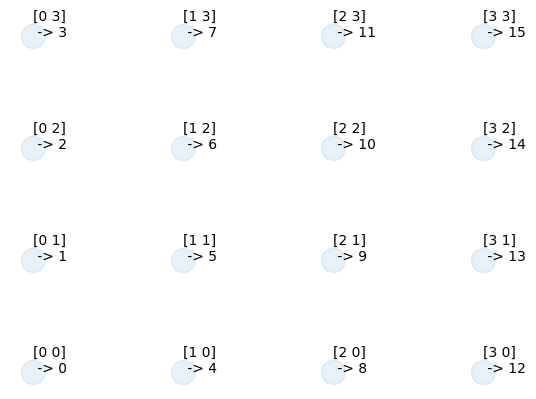

In [64]:
plt.scatter(*np.unique(indices2d, axis=0).T, s=300, alpha=0.1)
_, idx_unique = np.unique(indices, return_index=True)
for idx2d, idx1d in zip(indices2d[idx_unique], indices[idx_unique]):
	plt.annotate(f'{idx2d}\n -> {idx1d}', xy=idx2d)
plt.axis(False);

## diagonal

In [60]:
diag = DiagonalMapping(nx=4, ny=4)
indices_diag = diag.indices(rnn.F)
indices2d = diag.indices2d(rnn.F)

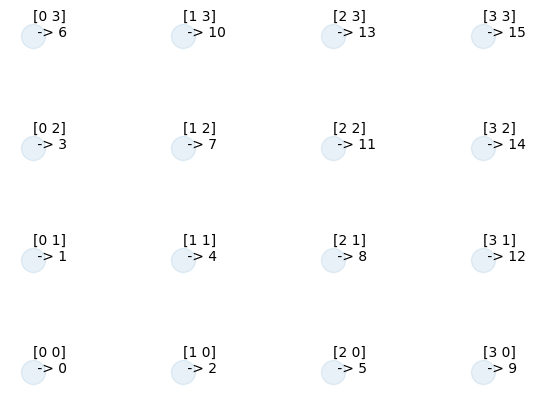

In [61]:
plt.scatter(*np.unique(indices2d, axis=0).T, s=300, alpha=0.1)
_, idx_unique = np.unique(indices_diag, return_index=True)
for idx2d, idx1d in zip(indices2d[idx_unique], indices_diag[idx_unique]):
	plt.annotate(f'{idx2d}\n -> {idx1d}', xy=idx2d)
plt.axis(False);

## far

In [19]:
def far_index(F: np.ndarray, n: int, box: Box, offset: int = 0, stride: int = 1) -> np.ndarray:
	indices = np.zeros(len(F), dtype=int)

	box1, box2, box4, box3 = box.split_quadrants()  # NOTE : reordering of the boxes

	mask1 = (box1.xmin <= F[:, 0]) & (F[:, 0] <  box1.xmax) & (box1.ymin <= F[:, 1]) & (F[:, 1] <  box1.ymax)
	mask2 = (box2.xmin <= F[:, 0]) & (F[:, 0] <= box2.xmax) & (box2.ymin <= F[:, 1]) & (F[:, 1] <  box2.ymax)
	mask3 = (box3.xmin <= F[:, 0]) & (F[:, 0] <= box3.xmax) & (box3.ymin <= F[:, 1]) & (F[:, 1] <= box3.ymax)
	mask4 = (box4.xmin <= F[:, 0]) & (F[:, 0] <  box4.xmax) & (box4.ymin <= F[:, 1]) & (F[:, 1] <= box4.ymax)

	if n == 1:
		indices[mask1] = offset+0*stride
		indices[mask2] = offset+1*stride
		indices[mask3] = offset+2*stride
		indices[mask4] = offset+3*stride
		return indices

	indices[mask1] = far_index(F[mask1, :], n-1, box1, offset=offset+0*stride, stride=stride*4)
	indices[mask2] = far_index(F[mask2, :], n-1, box2, offset=offset+1*stride, stride=stride*4)
	indices[mask3] = far_index(F[mask3, :], n-1, box3, offset=offset+2*stride, stride=stride*4)
	indices[mask4] = far_index(F[mask4, :], n-1, box4, offset=offset+3*stride, stride=stride*4)
	return indices

In [31]:
bbox = Box.new_bbox(rnn.F)
F = np.zeros((1000, 2))
F[:, 0] = np.random.default_rng(42).uniform(bbox.xmin, bbox.xmax, len(F))
F[:, 1] = np.random.default_rng(43).uniform(bbox.ymin, bbox.ymax, len(F))

In [49]:
far = FarMapping(nrec=3)
indices_far = far.indices(F, bbox)
indices2d = far.indices2d(F, bbox)

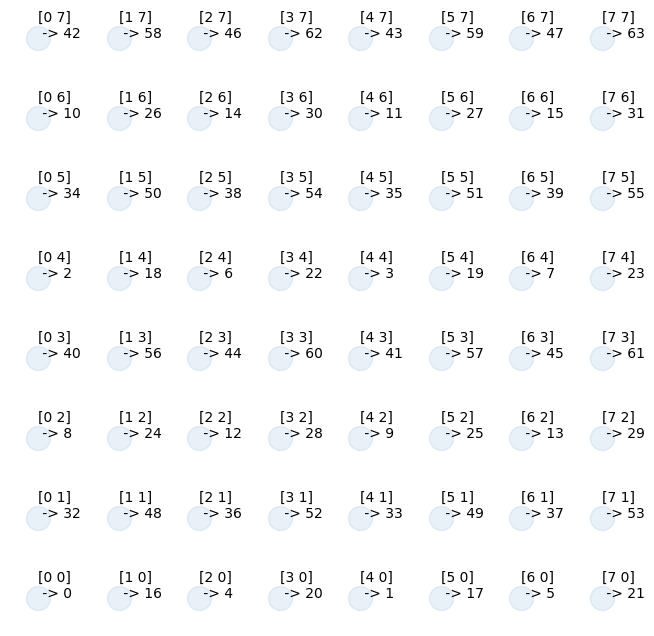

In [59]:
plt.figure(figsize=(8,8))
plt.scatter(*np.unique(indices2d, axis=0).T, s=300, alpha=0.1)
_, idx_unique = np.unique(indices_far, return_index=True)
for idx2d, idx1d in zip(indices2d[idx_unique], indices_far[idx_unique]):
	plt.annotate(f'{idx2d}\n -> {idx1d}', xy=idx2d)
	# plt.annotate(f'{idx1d}', xy=idx2d)
plt.axis(False);

## recursive quadrant

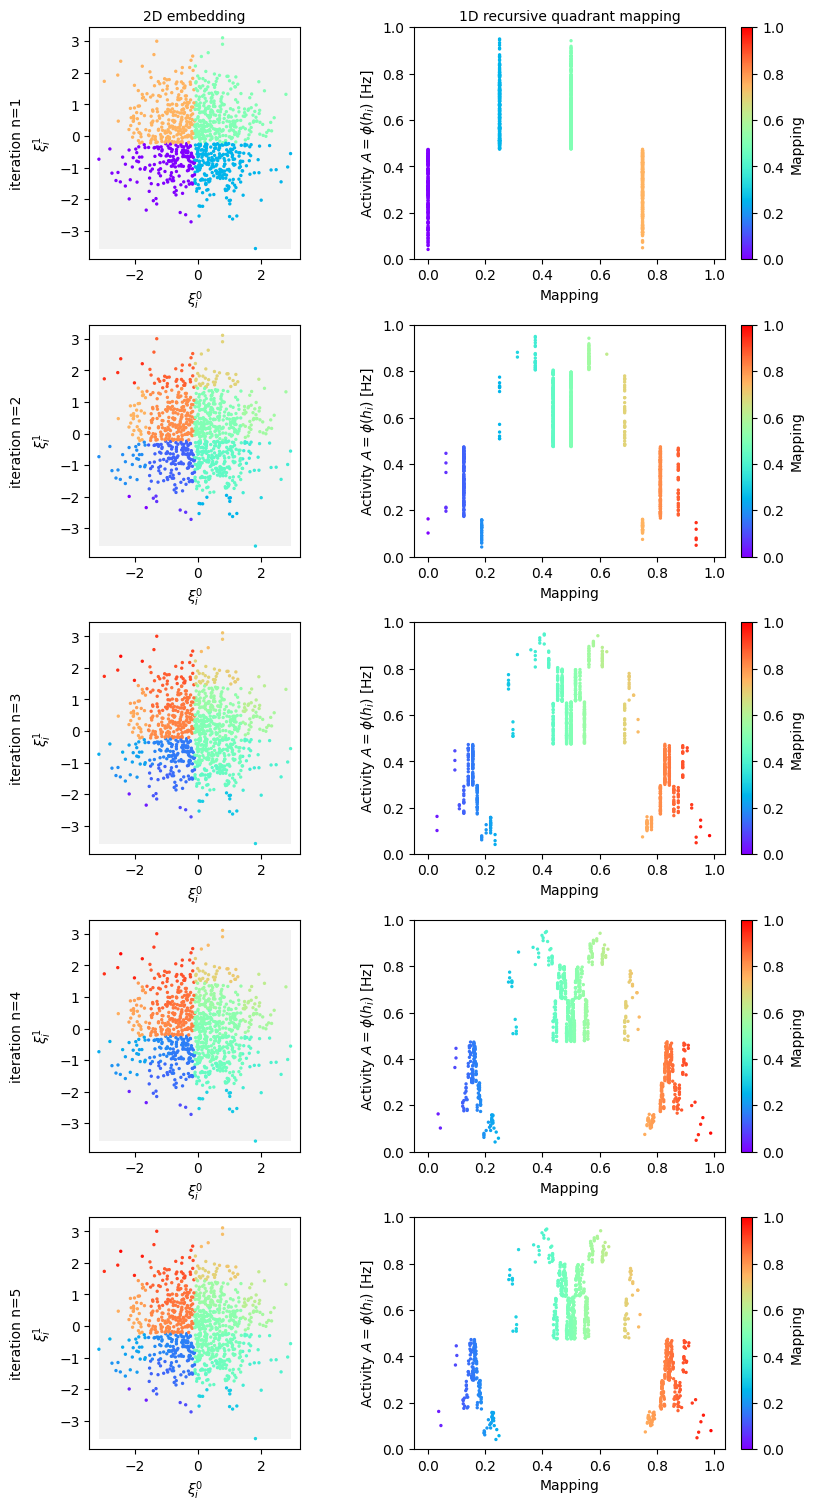

In [12]:
ns = [1, 2, 3, 4, 5]

fig, axes = plt.subplots(ncols=2, nrows=len(ns), figsize=(4*2, 3*len(ns)), constrained_layout=True, sharex='col')

for i, nrec in enumerate(ns):
	mapping = RecursiveQuadrantMapping(nrec)(rnn.F)
	bbox = Box(rnn.F[:, 0].min(), rnn.F[:, 0].max(), rnn.F[:, 1].min(), rnn.F[:, 1].max())
	axes[i, 0].add_patch(plt.Rectangle((bbox.xmin, bbox.ymin), bbox.xmax-bbox.xmin, bbox.ymax-bbox.ymin, fc='k', alpha=0.05))
	plot_2D_to_1D_mapping(rnn, mapping, activity, figax=(fig, axes[i, :]), cmap='rainbow', s=2, vmin=0, vmax=1)
	axes[i, 0].xaxis.set_tick_params(labelbottom=True)  # get ticks back
	axes[i, 1].xaxis.set_tick_params(labelbottom=True)  # get ticks back
	axes[i, 1].set_ylim((0, 1))

add_headers(fig, row_headers=[f'iteration {n=}' for n in ns])
add_headers(fig, col_headers=['2D embedding', '1D recursive quadrant mapping'])

plt.show()